# Predicting House Prices In Ames, Iowa
The Ames Housing data set was introduced in 2011 by Dean De Cock at Truman State University. It contains 2930 observations of 80 variables, divided more or less evenly among ordinal, nominal, continuous and discrete. With data from 2006-2010, De Cock intended to provide a contemporary alternative to the Boston Housing data set, which was compiled in the 70's.

In this notebook, I will clean and explore the data, then briefly optimize a handful of regression models for predicting 'Sale Price'.

---

### Import Packages

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pal = sns.color_palette("pastel").as_hex()

random.seed(10)

%matplotlib inline

---

# Cleaning the Data

In [3]:
# importing the training data
df = pd.read_csv('train.csv')

81 columns

Fixing typos found earlier

In [5]:
df.loc[1699,'Garage Yr Blt'] = 2007
df.loc[1712,'Garage Type'] = np.NaN
df.loc[1712,'Garage Cars'] = 0
df.loc[1712,'Garage Area'] = 0

Dropping 'Id' and 'PID' columns, which will not be needed

In [6]:
df.drop(['Id','PID'], axis=1, inplace=True)

### Converting categorical features to numerical features
A number of categorical features are clearly ordered, with qualitative values like 'Good', 'Fair', 'Poor', etc. These are converted into ordered, numerical equivalents using a dictionary of keys.

In [7]:
# features to be converted
to_cat = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual','Functional',
          'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Central Air', 'Garage Finish']

# keys for conversions
cat_key = {'five':
           {'Gd':3, 'TA':2, 'Ex':4, 'Po': 0, 'Fa':1},
           'five_NA':
           {'Gd':4, 'TA':3, 'Ex':5, 'Po': 1, 'Fa':2, 'N':0, np.NaN:0},
           'function':
           {'Typ':7, 'Mod':4, 'Min2':5, 'Maj1':3, 'Min1':6, 'Sev':1, 'Sal':0, 'Maj2':2},
           'binary':
           {'N':0, 'Y':1},
           'finish':
           {'RFn':2, 'Unf':1, 'Fin':3, np.NaN:0}}

# assigning each column a key dict
num_key = {'Exter Qual':'five', 'Exter Cond':'five', 'Bsmt Qual':'five_NA',
           'Bsmt Cond':'five_NA', 'Heating QC':'five', 'Kitchen Qual':'five',
           'Functional':'function', 'Fireplace Qu':'five_NA', 'Garage Qual':'five_NA',
           'Garage Cond':'five_NA', 'Pool QC':'five_NA', 'Central Air':'binary',
           'Garage Finish':'finish'}

# converting
for c in to_cat:
    p = str(f'{c}_num')
    df[p] = df[c].map(lambda x: cat_key[num_key[c]][x])

### Converting years to ages
A number of features list years (of construction, renovation, etc). To better standardize the data, they are converted to ages. 

In [8]:
# features to be converted
to_age = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']

# new feature names
age_names = ['House Age', 'Remod/Add Age', 'Garage Age', 'Years Since Sale']

# dictionary of old names and new names
ager = dict(zip(to_age,age_names))

# convert by subtracting from current year
for n, v in ager.items():
    df[v] = df[n].map(lambda x: 2018-x)

### Removing converted features

In [9]:
df.drop([c for c in to_age + to_cat], axis=1, inplace=True)

### Filling in missing values

In [10]:
nulls = {'col':[], 'null':[]}
for c in df.columns:
    if df[c].isnull().sum() > 0:
        nulls['col'].append(c)
        nulls['null'].append(df[c].isnull().sum())
        
pd.DataFrame(nulls)

,col,null
0,Lot Frontage,330
1,Alley,1911
2,Mas Vnr Type,22
3,Mas Vnr Area,22
4,Bsmt Exposure,58
5,BsmtFin Type 1,55
6,BsmtFin SF 1,1
7,BsmtFin Type 2,56
8,BsmtFin SF 2,1
9,Bsmt Unf SF,1


Given that we only have 2051 rows, dropping 'Alley', 'Fence' and 'Misc Feature'

In [11]:
df.drop(['Alley', 'Fence', 'Misc Feature'], axis=1, inplace=True)

Filling in missing 'Garage Age' values with same from 'House Age'.

In [12]:
df['Garage Age'].fillna(df['House Age'], inplace=True)

Imputing missing values for remaining features with column means for numericals and 'Unknown' for categoricals.

In [13]:
# recalculating null columns
nulls = {'col':[], 'null':[]}
for c in df.columns:
    if df[c].isnull().sum() > 0:
        nulls['col'].append(c)
        nulls['null'].append(df[c].isnull().sum())

# imputing missing values
for c in nulls['col']:
    if df[c].dtype == 'object':
        df[c].fillna('Unknown', inplace=True)
    if df[c].dtype == 'float64':
        df[c].fillna(df[c].mean(), inplace=True)

### Dummy columns
Convert unordered categorical features to numerical by making dummy columns

In [14]:
df_dummies = pd.get_dummies(df)

---

# Exploring the Data

Some visualizations and observations about the data. (Sometimes looking at the pre-cleaning data as needed.)

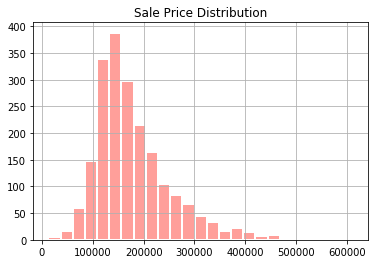

In [103]:
df.SalePrice.hist(color=pal[2], bins=25, ec='w', lw=2)
plt.title(s='Sale Price Distribution');

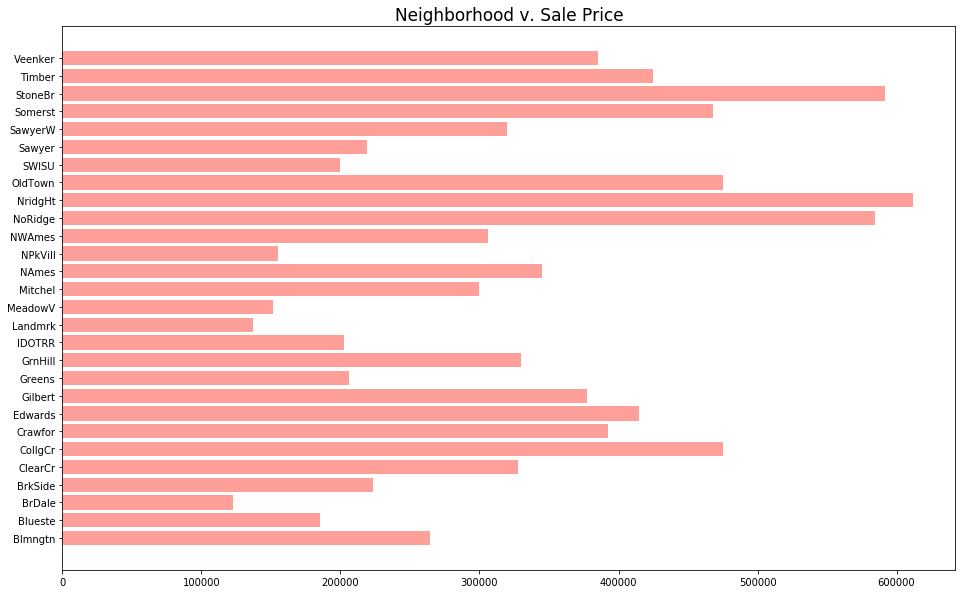

In [105]:
d = df[['Neighborhood','SalePrice']].sort_values('SalePrice', ascending=False)

plt.figure(figsize=(16,10))
plt.title(s='Neighborhood v. Sale Price', size=17)
plt.barh(data=d, y='Neighborhood', width='SalePrice', color=pal[2]);

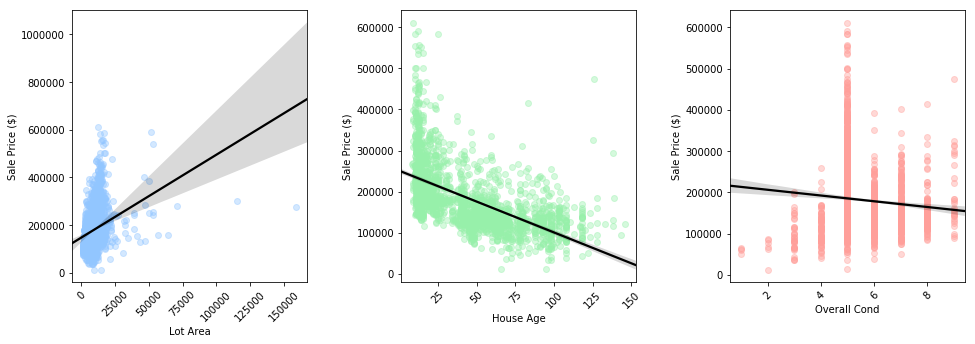

In [17]:
d = df
a = 0.4
feats = ['Lot Area', 'House Age', 'Overall Cond']

plt.figure(figsize=(16,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.4, hspace=None)
for n in range(3):
    plt.subplot(1,3,n+1)
    sns.regplot(data=d, x=feats[n],y='SalePrice', color=pal[n],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
    plt.xlabel(s=feats[n])
    plt.ylabel(s='Sale Price ($)')
    plt.xticks(rotation=45)

Correlation between 'Sale Price' and 'Lot Area' makes sense, as does an inverse correlation between 'Sale Price' and' House Age'. Surprisingly, 'Overall Cond' and 'Sale Price' seem barely related.

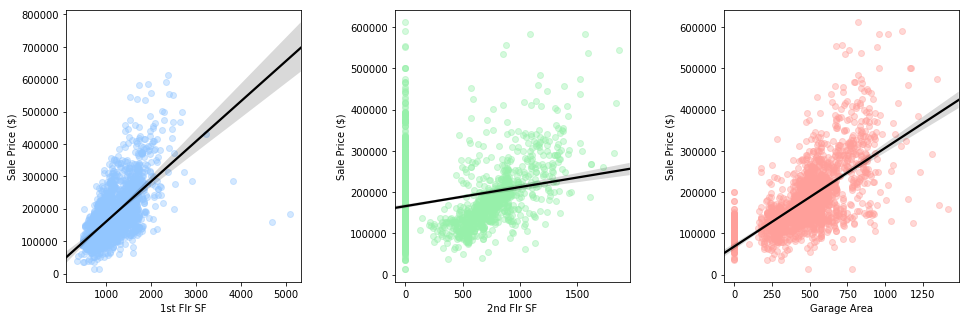

In [18]:
d = df
a = 0.4
feats = ['1st Flr SF', '2nd Flr SF', 'Garage Area']

plt.figure(figsize=(16,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.4, hspace=None)
for n in range(3):
    plt.subplot(1,3,n+1)
#     plt.scatter(data=d, x=feats[n],y='SalePrice', color=pal[n])
    sns.regplot(data=d, x=feats[n],y='SalePrice', color=pal[n],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
    plt.xlabel(s=feats[n])
    plt.ylabel(s='Sale Price ($)')

'1st Fl SF' looks affected by some outliers. '2nd Flr SF' and 'Garage Area' both look affected by the zero values. 

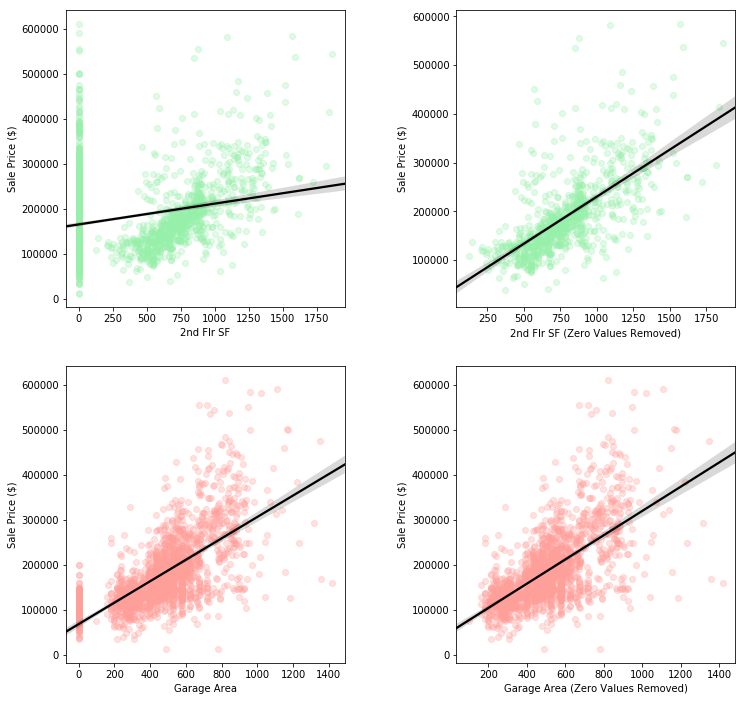

In [19]:
d = df[['SalePrice', '1st Flr SF', '2nd Flr SF', 'Garage Area']]
a = 0.3

plt.figure(figsize=(12,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.4, hspace=None)

plt.subplot(2,2,1)
sns.regplot(data=d, x='2nd Flr SF', y='SalePrice', color=pal[1],
           line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='2nd Flr SF')
plt.ylabel(s='Sale Price ($)')

plt.subplot(2,2,2)
sns.regplot(data=d[d['2nd Flr SF'] >0], x='2nd Flr SF', y='SalePrice', color=pal[1],
           line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='2nd Flr SF (Zero Values Removed)')
plt.ylabel(s='Sale Price ($)')

plt.subplot(2,2,3)
sns.regplot(data=d, x='Garage Area', y='SalePrice', color=pal[2],
           line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='Garage Area')
plt.ylabel(s='Sale Price ($)')

plt.subplot(2,2,4)
sns.regplot(data=d[d['Garage Area'] >0], x='Garage Area', y='SalePrice', color=pal[2],
           line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='Garage Area (Zero Values Removed)')
plt.ylabel(s='Sale Price ($)');

---

# Modeling and Predictions

Predicting housing price using three different algorithms.

### Creating a pipeline to combine standard scaling with the regressor

In [54]:
prf = Pipeline([
    ('ss', StandardScaler()),
    ('rfr', RandomForestRegressor())
])

psv = Pipeline([
    ('ss', StandardScaler()),
    ('svr', SVR())
])

pad = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostRegressor())
])


### Splitting the data for validation

In [21]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Initial scores
Scoring with Root Mean Squared Error, as per the Kaggle competition.

The function 'RMSE_score' returns a 5x cross-validated RMSE for a given model.

In [22]:
# creating a function to return 5x cross-validated RMSE

def RMSE_score(model, X, y, cv=5):
    return (np.mean(cross_val_score(prf, X_test, y_test, scoring='neg_mean_squared_error', cv=cv))*-1)**0.5

In [23]:
models = [prf, psv, pad]
model_scores = {
                'model':['Random Forest','SVR','AdaBoost'],
                'scores_1':[]
               }
for m in models:
    m.fit(X_train, y_train)
    RMSE = RMSE_score(m, X_test, y_test)
    model_scores['scores_1'].append(RMSE)
    print(f'{m.steps[1][0]} score:')
    print(RMSE)
    print('')

rfr score:
29854.4777408

svr score:
29697.6673884

ada score:
29424.7745198



A graphical look...

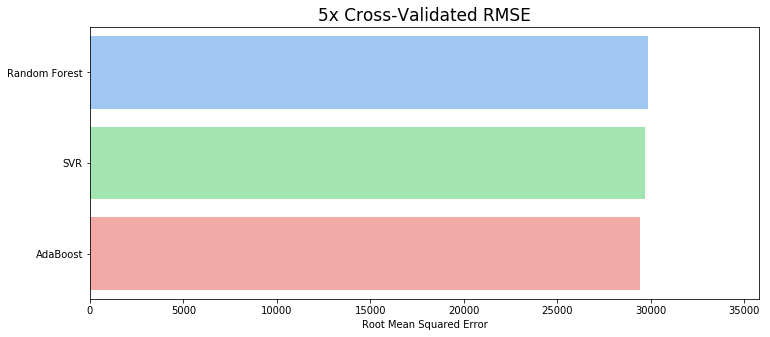

In [24]:
plt.figure(figsize=(12,5))
plt.title(s='5x Cross-Validated RMSE', size=17)
sns.barplot(data=model_scores, x='scores_1', y='model', palette=pal)
plt.xlabel('Root Mean Squared Error')
plt.margins(0.2);

Every model returns a score a shade below 30000.

### Improving the data?
Looking at the scatter plots above, a couple of the features look like they could benefit from converting to a log scale.

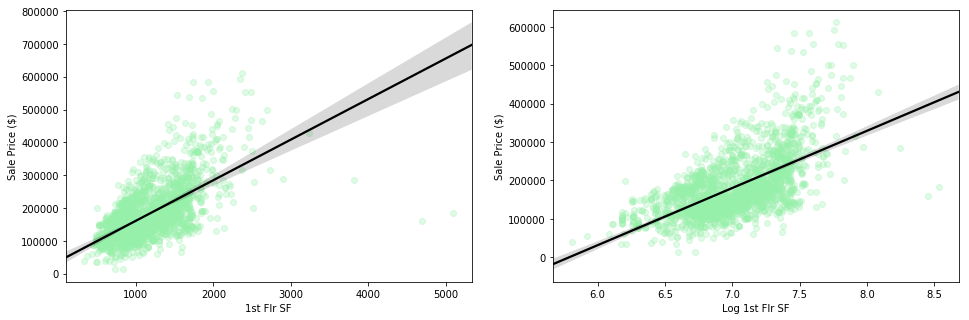

In [25]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.regplot(data=df, x='1st Flr SF',y='SalePrice', color=pal[1],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='1st Flr SF')
plt.ylabel(s='Sale Price ($)')

plt.subplot(1,2,2)
sns.regplot(data=df, x=np.log(d['1st Flr SF']),y='SalePrice', color=pal[1],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='Log 1st Flr SF')
plt.ylabel(s='Sale Price ($)');

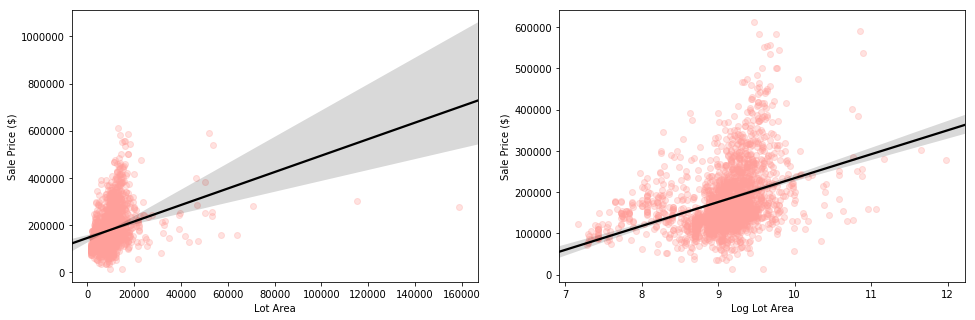

In [26]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.regplot(data=df, x='Lot Area',y='SalePrice', color=pal[2],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='Lot Area')
plt.ylabel(s='Sale Price ($)')

plt.subplot(1,2,2)
sns.regplot(data=df, x=np.log(df['Lot Area']),y='SalePrice', color=pal[2],
               line_kws={'color':'black'}, scatter_kws={'alpha':a})
plt.xlabel(s='Log Lot Area')
plt.ylabel(s='Sale Price ($)');

In [27]:
# converting to log
df_dummies['Log Lot Area'] = df_dummies['Lot Area'].map(lambda x: np.log(x))
df_dummies['Log 1st Flr SF'] = df_dummies['1st Flr SF'].map(lambda x: np.log(x))

# dropping columns
df_dummies.drop(['1st Flr SF','Lot Area'], axis=1, inplace=True)

Did the scores improve?

In [28]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
model_scores['scores_2'] = []
for m in models:
    m.fit(X_train, y_train)
    RMSE = RMSE_score(m, X_test, y_test)
    model_scores['scores_2'].append(RMSE)
    print(f'{m.steps[1][0]} score:')
    print(RMSE)
    print('')

rfr score:
29002.6115943

svr score:
29052.4535218

ada score:
28461.5800328



### Graphically...

In [30]:
# converting score data for graphing
scores = pd.DataFrame(model_scores)
scores = pd.melt(scores, id_vars='model', value_vars=['scores_1', 'scores_2'], value_name='RMSE_score', var_name='modeling round')

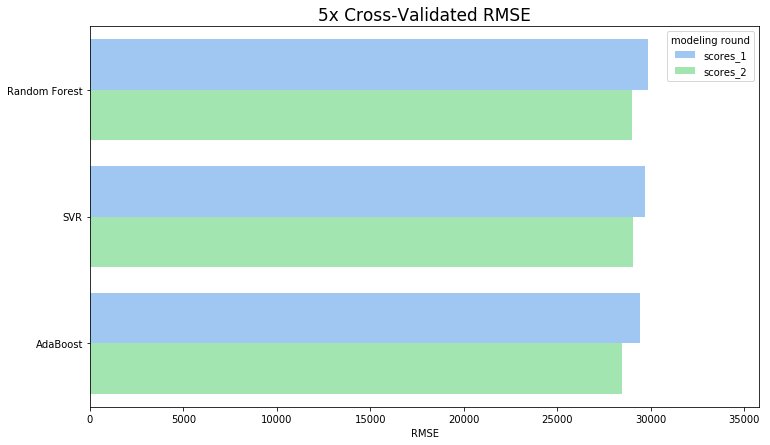

In [31]:
plt.figure(figsize=(12,7))
plt.title(s='5x Cross-Validated RMSE', size=17)
sns.barplot(data=scores, x='RMSE_score', y='model', hue='modeling round', palette=pal)
plt.ylabel('')
plt.xlabel('RMSE')
plt.margins(0.2);

Remember that RMSE measures error, so we are trying to minimize the score. Marginal improvements in all models.

Instead of tweaking the data, let's see if tuning our models brings the score down across the board.

---

# Modeling Tuning
Running a few GridSearches to optimize our four models.

### RandomForest
Searching for best parameters across 'n_estimators', 'max_features' and 'min_samples_split'.

In [42]:
# set params to search over
params = {
        'rfr__n_estimators':list(range(10,100, 20)),
        'rfr__max_features':[0.5, 'sqrt', 'log2', 'auto'],
        'rfr__min_samples_split':[2, 3, 5, 8]
        }

# instantiate Grid Search
gs_rfr = GridSearchCV(prf, param_grid=params, cv=5, scoring='neg_mean_squared_error')

In [43]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# fitting the Grid Search
gs_rfr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=N...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rfr__n_estimators': [10, 30, 50, 70, 90], 'rfr__max_features': [0.5, 'sqrt', 'log2', 'auto'], 'rfr__min_samples_split': [2, 3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
gs_rfr.best_params_

{'rfr__max_features': 0.5,
 'rfr__min_samples_split': 5,
 'rfr__n_estimators': 50}

In [47]:
(-gs_rfr.best_score_)**0.5

26035.783282401539

In [74]:
model_scores['scores_tuned'] = []

RMSE = RMSE_score(gs_rfr, X_test, y_test)
model_scores['scores_tuned'].append(RMSE)
print(RMSE)

29491.6725595


### SVR
Can we improve SVR by using a different kernel and adjusting 'C'?

In [77]:
# set params to search over
params = {
        'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'svr__C':[0.001, 0.01, 0.1, 1, 10]
        }

# instantiate Grid Search
gs_svr = GridSearchCV(psv, param_grid=params, cv=5, scoring='neg_mean_squared_error')

In [78]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [79]:
# fitting the Grid Search
gs_svr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'svr__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [80]:
# checking best params
gs_svr.best_params_

{'svr__C': 10, 'svr__kernel': 'linear'}

In [81]:
(-gs_svr.best_score_)**0.5

38420.215891234933

In [86]:
# new score?
RMSE = RMSE_score(gs_svr, X_test, y_test)
print(RMSE)

35289.7487668


What if we adjust 'C' and 'gamma'?

In [89]:
# resetting kernel in Pipeline
psv = Pipeline([
    ('ss', StandardScaler()),
    ('svr', SVR(kernel='linear'))
])

# set params to search over
params = {
        'svr__C':[0.001, 0.01, 0.1, 1, 10],
        'svr__gamma':[0.001, 0.01, 0.1, 1]
        }

# instantiate Grid Search
gs_svr = GridSearchCV(psv, param_grid=params, cv=5, scoring='neg_mean_squared_error')

In [90]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

# fitting the Grid Search
gs_svr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [0.001, 0.01, 0.1, 1, 10], 'svr__gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [91]:
gs_svr.best_params_

{'svr__C': 10, 'svr__gamma': 0.001}

In [92]:
# new score?
RMSE = RMSE_score(gs_svr, X_test, y_test)
model_scores['scores_tuned'].append(RMSE)
print(RMSE)

34941.5142229


### AdaBoost
Tweaking 'n_estimators', 'loss' and 'learning_rate'.

In [93]:
# set params to search over
params = {
        'ada__n_estimators':[50, 75, 100],
        'ada__loss':['linear', 'square', 'exponential'],
        'ada__learning_rate':[0.5, 1, 1.5]
        }

# instantiate Grid Search
gs_ada = GridSearchCV(pad, param_grid=params, cv=5, scoring='neg_mean_squared_error')

In [94]:
X = df_dummies.drop('SalePrice', axis=1)
y = df_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [95]:
gs_ada.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ada', AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ada__n_estimators': [50, 75, 100], 'ada__loss': ['linear', 'square', 'exponential'], 'ada__learning_rate': [0.5, 1, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
gs_ada.best_params_

{'ada__learning_rate': 0.5,
 'ada__loss': 'exponential',
 'ada__n_estimators': 50}

In [97]:
(-gs_ada.best_score_)**0.5

34156.274354159665

In [98]:
RMSE = RMSE_score(gs_ada, X_test, y_test)
model_scores['scores_tuned'].append(RMSE)
print(RMSE)

31379.466642


### How'd we do?
Let's compare the three rounds of scores graphically.

In [99]:
# converting score data for graphing
scores = pd.DataFrame(model_scores)
scores = pd.melt(scores, id_vars='model', value_vars=['scores_1', 'scores_2', 'scores_tuned'], value_name='RMSE_score', var_name='modeling round')

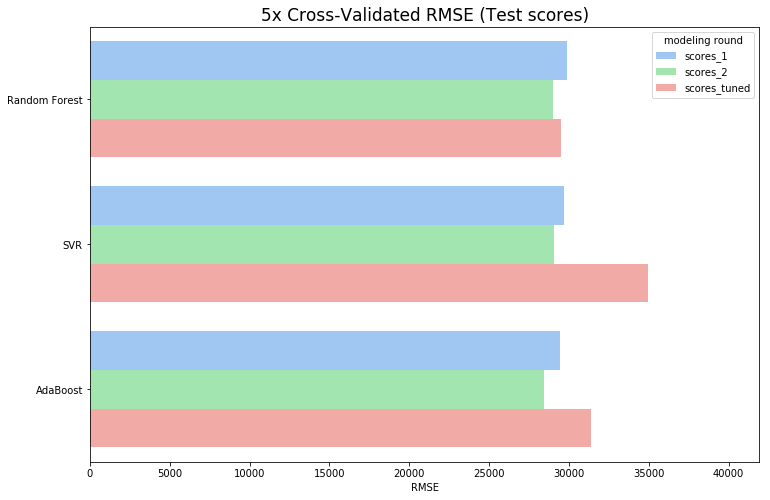

In [101]:
plt.figure(figsize=(12,8))
plt.title(s='5x Cross-Validated RMSE (Test scores)', size=17)
sns.barplot(data=scores, x='RMSE_score', y='model', hue='modeling round', palette=pal)
plt.ylabel('')
plt.xlabel('RMSE')
plt.margins(0.2);

Tuning actually made all three models worse.

---

# Interpretation and Conclusion
The benefits of model tuning entirely depend upon picking the right parameters to adjust over the right range of values. In this case, I probably could have chosen better.